In [99]:
import pandas as pd

# Load the dataset (update 'your_file.csv' with the actual file path)
df = pd.read_csv("cleaned_natural_disasters.csv")

# Filter entries for Spain
spain_entries = df[df["Country"] == "Spain"]

# Count the number of entries
num_spain_entries = len(spain_entries)

print(f"Number of entries from Spain: {num_spain_entries}")

Number of entries from Spain: 193


In [2]:
# Group by Disaster Type and count occurrences
disaster_counts = spain_entries["Disaster Type"].value_counts()

# Print results
print(disaster_counts)

Disaster Type
Flood                               42
Storm                               31
Water                               22
Wildfire                            19
Road                                14
Extreme temperature                 12
Rail                                 9
Fire (Miscellaneous)                 6
Air                                  6
Collapse (Miscellaneous)             5
Chemical spill                       5
Drought                              5
Explosion (Industrial)               4
Earthquake                           3
Miscellaneous accident (General)     3
Poisoning                            2
Epidemic                             2
Gas leak                             1
Mass movement (wet)                  1
Industrial accident (General)        1
Name: count, dtype: int64


In [3]:
# Filter entries for Europe
europe_entries = df[df["Region"] == "Europe"]

# Count the number of entries
num_europe_entries = len(europe_entries)

print(f"Number of entries from Europe: {num_europe_entries}")

Number of entries from Europe: 3399


In [4]:
# Group by Disaster Type and count occurrences
disaster_counts_europe = europe_entries["Disaster Type"].value_counts()

# Print results
print(disaster_counts_europe)

Disaster Type
Flood                               695
Storm                               611
Extreme temperature                 338
Air                                 268
Earthquake                          205
Water                               175
Road                                166
Rail                                154
Wildfire                            130
Explosion (Industrial)              124
Fire (Miscellaneous)                124
Mass movement (wet)                  86
Drought                              51
Epidemic                             39
Fire (Industrial)                    39
Explosion (Miscellaneous)            36
Miscellaneous accident (General)     35
Collapse (Miscellaneous)             33
Chemical spill                       32
Volcanic activity                    12
Poisoning                            10
Gas leak                             10
Collapse (Industrial)                 9
Industrial accident (General)         5
Radiation                 

Based on research, the following factors will be the most relavent to look at (they affect migrating birds the most):

- Storms
- Floods
- Wildfire

In [2]:
import pandas as pd 

# Load datasets
crane_df = pd.read_csv("cleaned_data_common_crane.csv", usecols=["COUNTRY", "LATITUDE", "LONGITUDE", "OBSERVATION DATE"], parse_dates=["OBSERVATION DATE"])
disaster_df = pd.read_csv("cleaned_natural_disasters.csv", usecols=["Country", "Disaster Type","Latitude", "Longitude", "Start Date", "End Date"], parse_dates=["Start Date", "End Date"])

# Merge datasets based on country
merged_df = crane_df.merge(disaster_df, left_on="COUNTRY", right_on="Country", how="inner")

# Ensure dates are in datetime format
merged_df["Start Date"] = pd.to_datetime(merged_df["Start Date"], errors="coerce")
merged_df["End Date"] = pd.to_datetime(merged_df["End Date"], errors="coerce")

# Drop rows where dates couldn't be converted (optional)
merged_df = merged_df.dropna(subset=["Start Date", "End Date"])

# Keep only observations within ±7 days of a disaster event
merged_df = merged_df[
    (merged_df["OBSERVATION DATE"] >= merged_df["Start Date"] - pd.Timedelta(days=7)) & 
    (merged_df["OBSERVATION DATE"] <= merged_df["End Date"] + pd.Timedelta(days=7))
]

# Save the merged dataset
merged_df.to_csv("merged_crane_disaster_data.csv", index=False)

print(f"Number of crane observations near disasters: {len(merged_df)}")



/var/folders/ff/bcb9x_dn5w33rzn_y_fyqfdh0000gn/T/ipykernel_48055/1011566952.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  merged_df["Start Date"] = pd.to_datetime(merged_df["Start Date"], errors="coerce")
/var/folders/ff/bcb9x_dn5w33rzn_y_fyqfdh0000gn/T/ipykernel_48055/1011566952.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  merged_df["End Date"] = pd.to_datetime(merged_df["End Date"], errors="coerce")


Number of crane observations near disasters: 83692


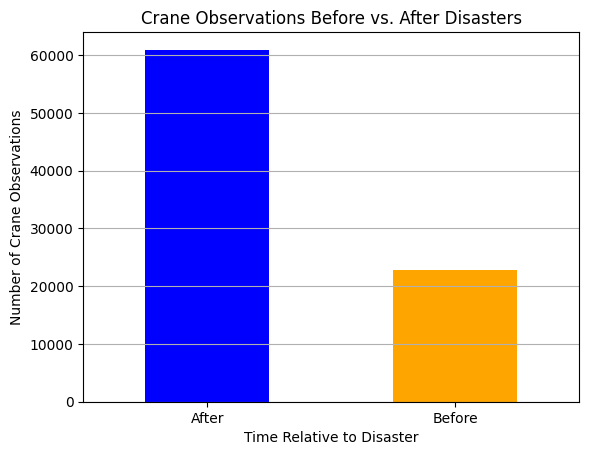

In [7]:
merged_df["Time Relative to Disaster"] = merged_df.apply(
    lambda row: "Before" if row["OBSERVATION DATE"] < row["Start Date"] else "After", axis=1
)

# Count observations
time_counts = merged_df["Time Relative to Disaster"].value_counts()

# Plot
import matplotlib.pyplot as plt
time_counts.plot(kind="bar", color=["blue", "orange"])
plt.xlabel("Time Relative to Disaster")
plt.ylabel("Number of Crane Observations")
plt.title("Crane Observations Before vs. After Disasters")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()


In [11]:
from scipy.stats import pearsonr

# Group by month
crane_monthly = merged_df.groupby(merged_df["OBSERVATION DATE"].dt.to_period("M")).size()
disaster_monthly = merged_df.groupby(merged_df["Start Date"].dt.to_period("M")).size()

# Align data
correlation_data = pd.DataFrame({"Crane Observations": crane_monthly, "Disaster Events": disaster_monthly}).fillna(0)

# Compute correlation
correlation, p_value = pearsonr(correlation_data["Crane Observations"], correlation_data["Disaster Events"])

print(f"Correlation between disasters and crane observations: {correlation:.3f} (p-value: {p_value:.5f})")


Correlation between disasters and crane observations: 0.625 (p-value: 0.00000)


### Spain Flooding

In [17]:
# Filter for floods in Spain
floods_spain = disaster_df[
    (disaster_df["Disaster Type"] == "Flood") & 
    (disaster_df["Country"] == "Spain")
]

In [18]:
# Convert observation date to datetime format
merged_df["OBSERVATION DATE"] = pd.to_datetime(merged_df["OBSERVATION DATE"])

# Filter for crane observations in Spain during winter months
cranes_spain_winter = merged_df[
    (merged_df["COUNTRY"] == "Spain") &
    (merged_df["OBSERVATION DATE"].dt.month.isin([11, 12, 1, 2]))
]


In [24]:
# Merge crane observations with flood data
merged_floods_cranes = cranes_spain_winter.merge(
    floods_spain, left_on="COUNTRY", right_on="Country", how="inner"
)

# Convert Start Date and Observation Date to datetime
merged_floods_cranes["Start Date_y"] = pd.to_datetime(merged_floods_cranes["Start Date_y"])
merged_floods_cranes["OBSERVATION DATE"] = pd.to_datetime(merged_floods_cranes["OBSERVATION DATE"])

# Filter crane observations within ±7 days of a flood
merged_floods_cranes = merged_floods_cranes[
    (merged_floods_cranes["OBSERVATION DATE"] >= merged_floods_cranes["Start Date_y"] - pd.Timedelta(days=7)) & 
    (merged_floods_cranes["OBSERVATION DATE"] <= merged_floods_cranes["Start Date_y"] + pd.Timedelta(days=7))
]

# Check how many crane observations are near floods
print(f"Number of crane observations near floods in Spain: {len(merged_floods_cranes)}")


Number of crane observations near floods in Spain: 4511


/var/folders/ff/bcb9x_dn5w33rzn_y_fyqfdh0000gn/T/ipykernel_48055/195186586.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  merged_floods_cranes["Start Date_y"] = pd.to_datetime(merged_floods_cranes["Start Date_y"])


In [22]:
merged_floods_cranes.head()

,COUNTRY,LATITUDE,LONGITUDE,OBSERVATION DATE,Disaster Type_x,Country_x,Latitude_x,Longitude_x,Start Date_x,End Date_x,Time Relative to Disaster,Month,Disaster Type_y,Country_y,Latitude_y,Longitude_y,Start Date_y,End Date_y
0,Spain,40.556807,-3.704436,1985-02-15,Air,Spain,40.365008,-3.651625,1985-02-20,1985-02-20,Before,1985-02,Flood,Spain,15.1,36.72,16/10/1940,20/10/1940
1,Spain,40.556807,-3.704436,1985-02-15,Air,Spain,40.365008,-3.651625,1985-02-20,1985-02-20,Before,1985-02,Flood,Spain,15.1,36.72,10/10/1953,10/10/1953
2,Spain,40.556807,-3.704436,1985-02-15,Air,Spain,40.365008,-3.651625,1985-02-20,1985-02-20,Before,1985-02,Flood,Spain,15.1,36.72,23/10/1957,23/10/1957
3,Spain,40.556807,-3.704436,1985-02-15,Air,Spain,40.365008,-3.651625,1985-02-20,1985-02-20,Before,1985-02,Flood,Spain,15.1,36.72,27/09/1962,27/09/1962
4,Spain,40.556807,-3.704436,1985-02-15,Air,Spain,40.365008,-3.651625,1985-02-20,1985-02-20,Before,1985-02,Flood,Spain,15.1,36.72,24/11/1972,24/11/1972


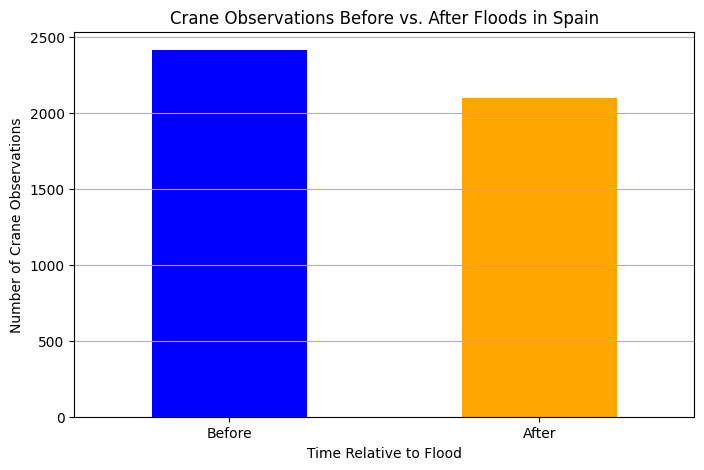

In [25]:
import matplotlib.pyplot as plt

# Categorize observations as before/after flood
merged_floods_cranes["Time Relative to Flood"] = merged_floods_cranes.apply(
    lambda row: "Before" if row["OBSERVATION DATE"] < row["Start Date_y"] else "After", axis=1
)

# Count occurrences
flood_time_counts = merged_floods_cranes["Time Relative to Flood"].value_counts()

# Plot
plt.figure(figsize=(8, 5))
flood_time_counts.plot(kind="bar", color=["blue", "orange"])
plt.xlabel("Time Relative to Flood")
plt.ylabel("Number of Crane Observations")
plt.title("Crane Observations Before vs. After Floods in Spain")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()


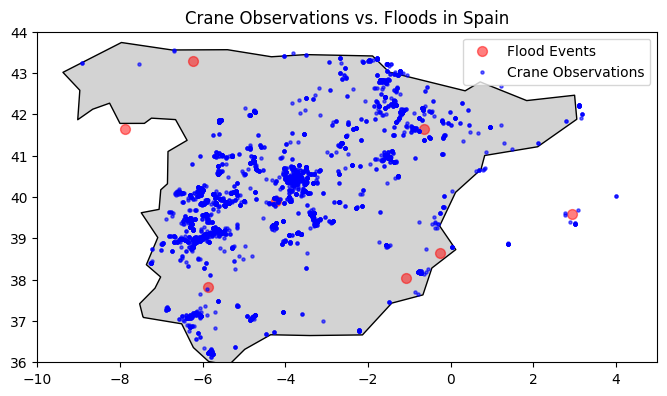

In [28]:
import geopandas as gpd

# Convert to GeoDataFrame
gdf_cranes = gpd.GeoDataFrame(merged_floods_cranes, geometry=gpd.points_from_xy(merged_floods_cranes["LONGITUDE"], merged_floods_cranes["LATITUDE"]))
gdf_floods = gpd.GeoDataFrame(floods_spain, geometry=gpd.points_from_xy(floods_spain["Longitude"], floods_spain["Latitude"]))


# Load Spain map (your shapefile)
world = gpd.read_file("110m_cultural/ne_110m_admin_0_countries.shp")

# Filter for Spain
spain = world[world["ADMIN"] == "Spain"]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
spain.plot(ax=ax, color="lightgrey", edgecolor="black")

# Plot floods
gdf_floods.plot(ax=ax, markersize=50, color="red", alpha=0.5, label="Flood Events")

# Plot cranes
gdf_cranes.plot(ax=ax, markersize=5, color="blue", alpha=0.6, label="Crane Observations")

# Set the limits for the latitude and longitude to zoom in on Spain
ax.set_xlim(-10, 5)   # Longitude range for Spain
ax.set_ylim(36, 44)   # Latitude range for Spain

plt.legend()
plt.title("Crane Observations vs. Floods in Spain")
plt.show()


### For every point

/var/folders/ff/bcb9x_dn5w33rzn_y_fyqfdh0000gn/T/ipykernel_48055/2175994756.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest = nearest_points(crane_point, flood_points.unary_union)


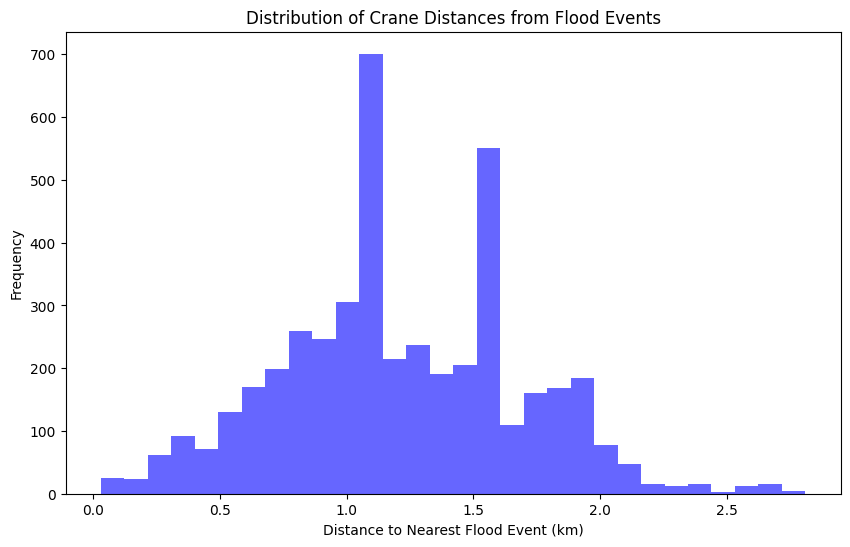

In [31]:
# Calculate the distance between each crane observation and the closest flood site
from shapely.ops import nearest_points

# Create a GeoDataFrame for flood sites and crane observations (ensuring both use the same CRS)
gdf_floods = gdf_floods.set_crs("EPSG:4326", allow_override=True)
gdf_cranes = gdf_cranes.set_crs("EPSG:4326", allow_override=True)

# Function to calculate nearest flood site for each crane observation
def nearest_distance(crane_point, flood_points):
    nearest = nearest_points(crane_point, flood_points.unary_union)
    return crane_point.distance(nearest[1])

# Apply the function to calculate distances for each crane observation
gdf_cranes["distance_to_flood"] = gdf_cranes.geometry.apply(lambda x: nearest_distance(x, gdf_floods.geometry))

# Plot the histogram of distances (this will show how far cranes are from floods)
plt.figure(figsize=(10, 6))
gdf_cranes["distance_to_flood"].plot(kind="hist", bins=30, color="blue", alpha=0.6)
plt.xlabel("Distance to Nearest Flood Event (km)")
plt.ylabel("Frequency")
plt.title("Distribution of Crane Distances from Flood Events")
plt.show()


/var/folders/ff/bcb9x_dn5w33rzn_y_fyqfdh0000gn/T/ipykernel_48055/983071555.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest = nearest_points(crane_point, flood_points.unary_union)


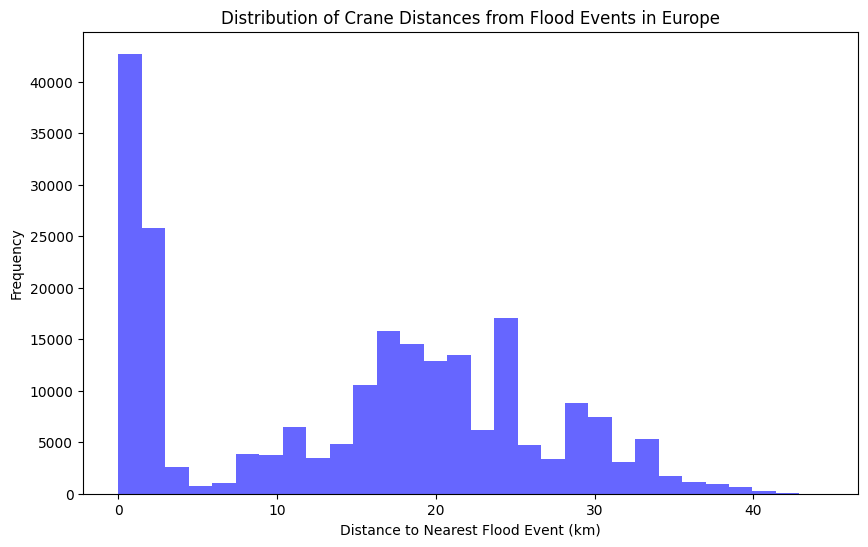

In [91]:
# Define the geographical bounds for Europe
min_lat = 35
max_lat = 71
min_lon = -25
max_lon = 40

# Filter crane observations within the specified bounds
gdf_cranes_europe = gdf_cranes.cx[min_lon:max_lon, min_lat:max_lat]

# Filter flood events within the specified bounds
gdf_floods_europe = gdf_floods.cx[min_lon:max_lon, min_lat:max_lat]

# Ensure both GeoDataFrames are using the same CRS (EPSG:4326)
gdf_cranes_europe = gdf_cranes_europe.set_crs("EPSG:4326", allow_override=True)
gdf_floods_europe = gdf_floods_europe.set_crs("EPSG:4326", allow_override=True)

# Perform distance calculation for the filtered data
from shapely.ops import nearest_points

def nearest_distance(crane_point, flood_points):
    nearest = nearest_points(crane_point, flood_points.unary_union)
    return crane_point.distance(nearest[1])

# Apply the function to calculate distances for each crane observation
gdf_cranes_europe["distance_to_flood"] = gdf_cranes_europe.geometry.apply(lambda x: nearest_distance(x, gdf_floods_europe.geometry))

# Plot the histogram of distances for the filtered European data
plt.figure(figsize=(10, 6))
gdf_cranes_europe["distance_to_flood"].plot(kind="hist", bins=30, color="blue", alpha=0.6)
plt.xlabel("Distance to Nearest Flood Event (km)")
plt.ylabel("Frequency")
plt.title("Distribution of Crane Distances from Flood Events in Europe")
plt.show()


/var/folders/ff/bcb9x_dn5w33rzn_y_fyqfdh0000gn/T/ipykernel_48055/585768577.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest = nearest_points(crane_point, flood_points.unary_union)


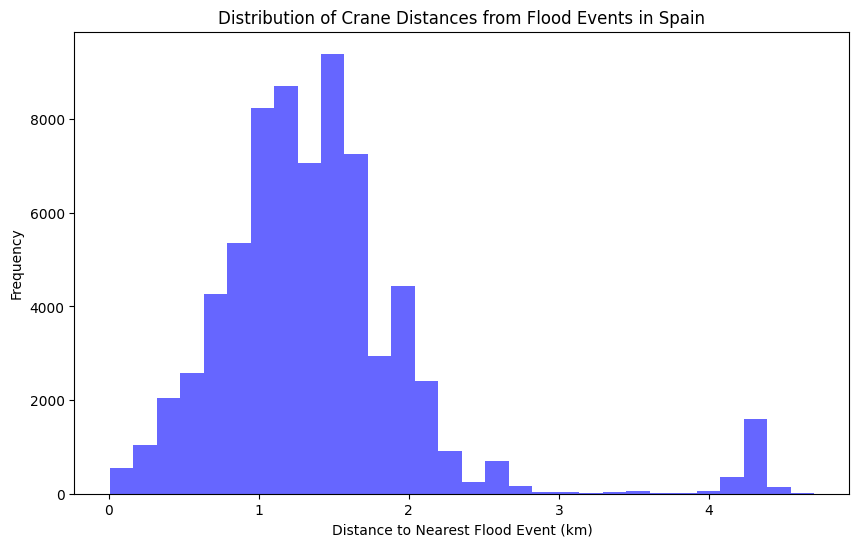

In [92]:
# Define the geographical bounds for Spain
min_lat_spain = 36
max_lat_spain = 44
min_lon_spain = -10
max_lon_spain = 5

# Filter crane observations within the specified bounds for Spain
gdf_cranes_spain = gdf_cranes.cx[min_lon_spain:max_lon_spain, min_lat_spain:max_lat_spain]

# Filter flood events within the specified bounds for Spain
gdf_floods_spain = gdf_floods.cx[min_lon_spain:max_lon_spain, min_lat_spain:max_lat_spain]

# Ensure both GeoDataFrames are using the same CRS (EPSG:4326)
gdf_cranes_spain = gdf_cranes_spain.set_crs("EPSG:4326", allow_override=True)
gdf_floods_spain = gdf_floods_spain.set_crs("EPSG:4326", allow_override=True)

# Perform distance calculation for the filtered data (Spain)
from shapely.ops import nearest_points

def nearest_distance(crane_point, flood_points):
    nearest = nearest_points(crane_point, flood_points.unary_union)
    return crane_point.distance(nearest[1])

# Apply the function to calculate distances for each crane observation in Spain
gdf_cranes_spain["distance_to_flood"] = gdf_cranes_spain.geometry.apply(lambda x: nearest_distance(x, gdf_floods_spain.geometry))

# Plot the histogram of distances for the filtered Spain data
plt.figure(figsize=(10, 6))
gdf_cranes_spain["distance_to_flood"].plot(kind="hist", bins=30, color="blue", alpha=0.6)
plt.xlabel("Distance to Nearest Flood Event (km)")
plt.ylabel("Frequency")
plt.title("Distribution of Crane Distances from Flood Events in Spain")
plt.show()


In [32]:
from scipy.stats import ttest_ind

# Split crane observations into 'before' and 'after' the flood event
before_floods = gdf_cranes[gdf_cranes["Time Relative to Flood"] == "Before"]["distance_to_flood"]
after_floods = gdf_cranes[gdf_cranes["Time Relative to Flood"] == "After"]["distance_to_flood"]

# Perform a t-test to check if the distance is significantly different before vs. after the flood
t_stat, p_value = ttest_ind(before_floods, after_floods)

# Print results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# If p-value is small (e.g., < 0.05), there is a significant difference
if p_value < 0.05:
    print("There is a significant difference in the distances before vs. after floods.")
else:
    print("There is no significant difference in the distances before vs. after floods.")


T-statistic: -6.957205314852911
P-value: 3.969645896066175e-12
There is a significant difference in the distances before vs. after floods.


### Spain Storms

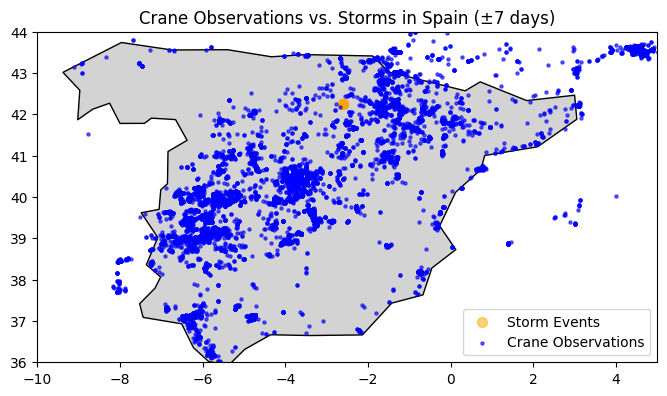

Number of crane observations near storms in Spain: 49475


In [38]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Convert Start Date and Observation Date to datetime
merged_df["Start Date"] = pd.to_datetime(merged_df["Start Date"])
merged_df["OBSERVATION DATE"] = pd.to_datetime(merged_df["OBSERVATION DATE"])

# Filter for storm events
storms_spain = merged_df[merged_df["Disaster Type"] == "Storm"]

# Convert Storm Data to GeoDataFrame
gdf_storms = gpd.GeoDataFrame(storms_spain, geometry=gpd.points_from_xy(storms_spain["Longitude"], storms_spain["Latitude"]))

# Filter crane observations based on ±7 days of storm events
merged_storms_cranes = merged_df[
    (merged_df["OBSERVATION DATE"] >= merged_df["Start Date"] - pd.Timedelta(days=7)) & 
    (merged_df["OBSERVATION DATE"] <= merged_df["Start Date"] + pd.Timedelta(days=7))
]

# Convert crane data to GeoDataFrame
gdf_cranes = gpd.GeoDataFrame(merged_storms_cranes, geometry=gpd.points_from_xy(merged_storms_cranes["LONGITUDE"], merged_storms_cranes["LATITUDE"]))

# Load Spain map (shapefile)
world = gpd.read_file("110m_cultural/ne_110m_admin_0_countries.shp")
spain = world[world["ADMIN"] == "Spain"]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot Spain map
spain.plot(ax=ax, color="lightgrey", edgecolor="black")

# Plot storm events
gdf_storms.plot(ax=ax, markersize=50, color="orange", alpha=0.5, label="Storm Events")

# Plot crane observations
gdf_cranes.plot(ax=ax, markersize=5, color="blue", alpha=0.6, label="Crane Observations")

# Set the limits for the latitude and longitude to zoom in on Spain
ax.set_xlim(-10, 5)   # Longitude range for Spain
ax.set_ylim(36, 44)   # Latitude range for Spain

plt.legend()
plt.title("Crane Observations vs. Storms in Spain (±7 days)")
plt.show()

# Check how many crane observations are near storms
print(f"Number of crane observations near storms in Spain: {len(merged_storms_cranes)}")


In [37]:
print(f"Number of storm events in Spain: {len(storms_spain)}")


Number of storm events in Spain: 17235


In [39]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Filter crane observations for Spain
crane_spain = merged_df[merged_df['COUNTRY'] == "Spain"]

# Filter disaster events for Spain (Floods and Storms)
disaster_spain = merged_df[merged_df['COUNTRY'] == "Spain"]


In [40]:
# Convert crane data to GeoDataFrame
gdf_cranes = gpd.GeoDataFrame(crane_spain, geometry=gpd.points_from_xy(crane_spain["LONGITUDE"], crane_spain["LATITUDE"]))

# Convert disaster data to GeoDataFrame
gdf_disasters = gpd.GeoDataFrame(disaster_spain, geometry=gpd.points_from_xy(disaster_spain["Longitude"], disaster_spain["Latitude"]))


In [41]:
# Load world map and filter for Spain
world = gpd.read_file("110m_cultural/ne_110m_admin_0_countries.shp")
spain = world[world["ADMIN"] == "Spain"]


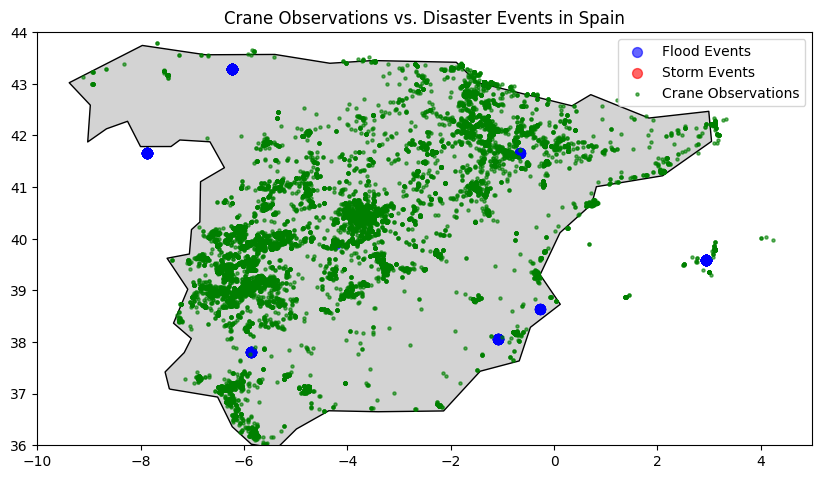

In [42]:
# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot Spain map
spain.plot(ax=ax, color="lightgrey", edgecolor="black")

# Plot disaster events (Floods and Storms)
gdf_disasters[gdf_disasters["Disaster Type"] == "Flood"].plot(ax=ax, markersize=50, color="blue", alpha=0.6, label="Flood Events")
gdf_disasters[gdf_disasters["Disaster Type"] == "Storm"].plot(ax=ax, markersize=50, color="red", alpha=0.6, label="Storm Events")

# Plot crane observations
gdf_cranes.plot(ax=ax, markersize=5, color="green", alpha=0.6, label="Crane Observations")

# Set the limits for the latitude and longitude to zoom in on Spain
ax.set_xlim(-10, 5)   # Longitude range for Spain
ax.set_ylim(36, 44)   # Latitude range for Spain

# Add labels and legend
plt.legend()
plt.title("Crane Observations vs. Disaster Events in Spain")
plt.show()


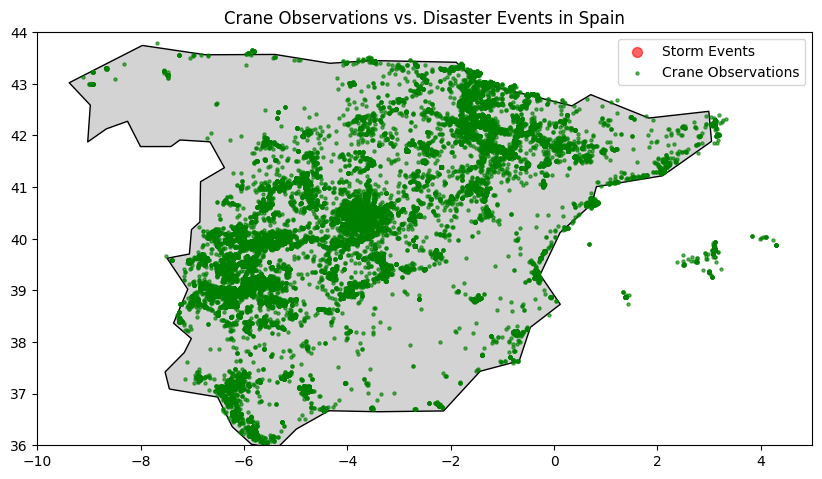

In [48]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load crane and disaster datasets
crane_df = pd.read_csv("cleaned_data_common_crane.csv", usecols=["COUNTRY", "LATITUDE", "LONGITUDE", "OBSERVATION DATE"], parse_dates=["OBSERVATION DATE"])
disaster_df = pd.read_csv("cleaned_natural_disasters.csv", usecols=["Country", "Disaster Type","Latitude", "Longitude", "Start Date", "End Date"], parse_dates=["Start Date", "End Date"])

# Filter crane data for Spain
crane_spain = crane_df[crane_df['COUNTRY'] == "Spain"]

# Filter disaster data for Spain
disaster_spain = disaster_df[disaster_df['Country'] == "Spain"]

# Convert crane data to GeoDataFrame
gdf_cranes = gpd.GeoDataFrame(crane_spain, geometry=gpd.points_from_xy(crane_spain["LONGITUDE"], crane_spain["LATITUDE"]))

# Convert disaster data to GeoDataFrame
gdf_disasters = gpd.GeoDataFrame(disaster_spain, geometry=gpd.points_from_xy(disaster_spain["Longitude"], disaster_spain["Latitude"]))

# Load world map and filter for Spain
world = gpd.read_file("110m_cultural/ne_110m_admin_0_countries.shp")
spain = world[world["ADMIN"] == "Spain"]

# Plot the map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the map of Spain
spain.plot(ax=ax, color="lightgrey", edgecolor="black")

# Plot disaster events (Floods and Storms)
gdf_disasters[gdf_disasters["Disaster Type"] == "Storm"].plot(ax=ax, markersize=50, color="red", alpha=0.6, label="Storm Events")

# Plot crane observations
gdf_cranes.plot(ax=ax, markersize=5, color="green", alpha=0.6, label="Crane Observations")

# Set the limits for the latitude and longitude to zoom in on Spain
ax.set_xlim(-10, 5)   # Longitude range for Spain
ax.set_ylim(36, 44)   # Latitude range for Spain

# Add labels and legend
plt.legend()
plt.title("Crane Observations vs. Disaster Events in Spain")
plt.show()


In [45]:
storms = gdf_disasters[gdf_disasters["Disaster Type"] == "Storm"]
print(storms.shape)  # Print the number of rows (should be > 0 if there are storms)

(31, 7)


In [46]:

print(storms[['Latitude', 'Longitude']].head())

      Latitude  Longitude
625    19.4328    104.125
2053   19.4328    104.125
2186   19.4328    104.125
3922   19.4328    104.125
4018   19.4328    104.125


These coordinates do not line up with spain. Some points should line up with, for example, the Leon Province, but the longitiude and latitude are wrong.

### All of Europe

In [67]:
# Load world map and filter for Spain
world = gpd.read_file("110m_cultural/ne_110m_admin_0_countries.shp")
europe = world[world["CONTINENT"] == "Europe"]

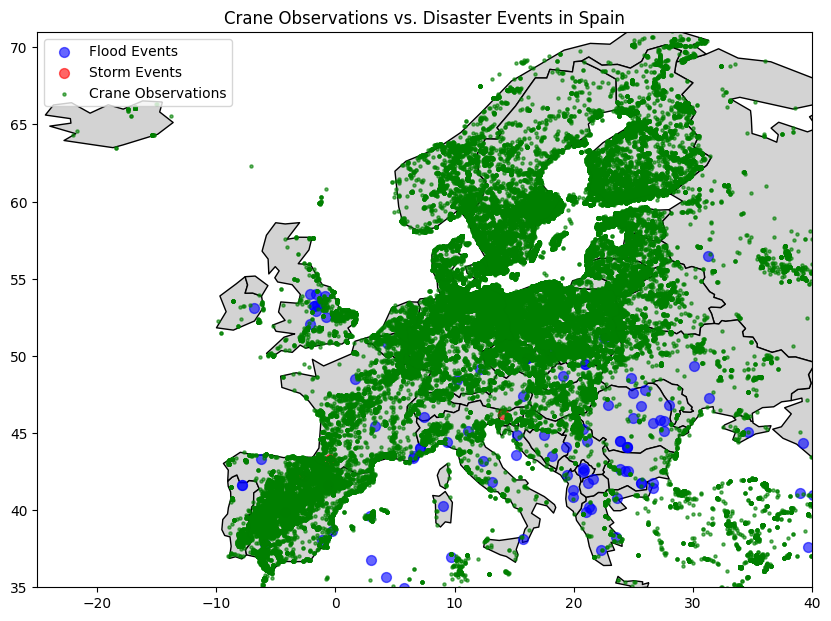

In [69]:
# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot Spain map
europe.plot(ax=ax, color="lightgrey", edgecolor="black")

# Plot disaster events (Floods and Storms)
gdf_disasters[gdf_disasters["Disaster Type"] == "Flood"].plot(ax=ax, markersize=50, color="blue", alpha=0.6, label="Flood Events")
gdf_disasters[gdf_disasters["Disaster Type"] == "Storm"].plot(ax=ax, markersize=50, color="red", alpha=0.6, label="Storm Events")

# Plot crane observations
gdf_cranes.plot(ax=ax, markersize=5, color="green", alpha=0.6, label="Crane Observations")

# Set the limits for the latitude and longitude to zoom in on Europe
ax.set_xlim(-25, 40)   # Longitude range for Europe
ax.set_ylim(35, 71)    # Latitude range for Europe


# Add labels and legend
plt.legend()
plt.title("Crane Observations vs. Disaster Events in Spain")
plt.show()

In [74]:
# Descriptive statistics
distance_stats = gdf_cranes["distance_to_flood_km"].describe()
print(distance_stats)


count    269452.000000
mean       2152.871683
std        1985.056716
min           0.721403
25%         263.043667
50%        2004.640130
75%        2824.355046
max       18021.204100
Name: distance_to_flood_km, dtype: float64


In [78]:
# Convert the observation date to datetime if it's not already in that format
gdf_cranes["OBSERVATION DATE"] = pd.to_datetime(gdf_cranes["OBSERVATION DATE"])

# Extract the month and season (for example, winter, spring, summer, fall)
gdf_cranes["Month"] = gdf_cranes["OBSERVATION DATE"].dt.month
gdf_cranes["Season"] = gdf_cranes["Month"].apply(lambda x: 'Winter' if x in [12, 1, 2] else 
                                                        ('Spring' if x in [3, 4, 5] else 
                                                        ('Summer' if x in [6, 7, 8] else 'Fall')))

# Group by season and calculate the average distance to flood
seasonal_distance = gdf_cranes.groupby("Season")["distance_to_flood_km"].mean()
print(seasonal_distance)



Season
Fall      1646.401442
Spring    2613.764597
Summer    2949.187973
Winter    1792.261905
Name: distance_to_flood_km, dtype: float64


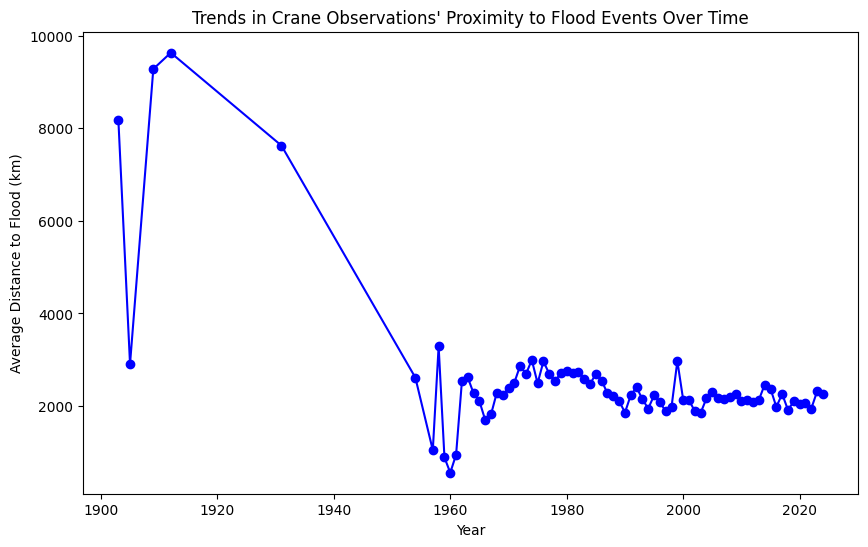

In [79]:
# Group by year or month to see how distances change over time
gdf_cranes["Year"] = gdf_cranes["OBSERVATION DATE"].dt.year
monthly_distance = gdf_cranes.groupby("Year")["distance_to_flood_km"].mean()

# Plot the time series
plt.figure(figsize=(10, 6))
monthly_distance.plot(kind="line", color="blue", marker="o")
plt.xlabel("Year")
plt.ylabel("Average Distance to Flood (km)")
plt.title("Trends in Crane Observations' Proximity to Flood Events Over Time")
plt.show()


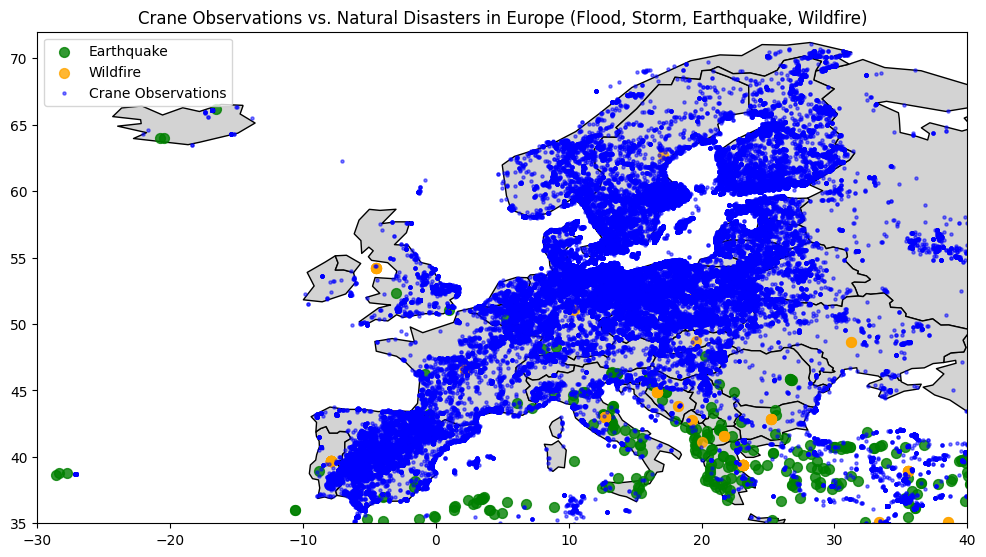

In [71]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load crane and disaster data
crane_df = pd.read_csv("cleaned_data_common_crane.csv", usecols=["COUNTRY", "LATITUDE", "LONGITUDE", "OBSERVATION DATE"], parse_dates=["OBSERVATION DATE"])
disaster_df = pd.read_csv("cleaned_natural_disasters.csv", usecols=["Country", "Disaster Type", "Latitude", "Longitude", "Start Date", "End Date"], parse_dates=["Start Date", "End Date"])

# Filter disaster data for the specific types: Flood, Storm, Earthquake, Wildfire
disaster_types_of_interest = ['Flood', 'Storm', 'Earthquake', 'Wildfire']
disasters_europe = disaster_df[disaster_df['Disaster Type'].isin(disaster_types_of_interest)]

# Convert disaster data to GeoDataFrame
gdf_disasters = gpd.GeoDataFrame(disasters_europe, geometry=gpd.points_from_xy(disasters_europe["Longitude"], disasters_europe["Latitude"]))

# Convert crane data to GeoDataFrame
gdf_cranes = gpd.GeoDataFrame(crane_df, geometry=gpd.points_from_xy(crane_df["LONGITUDE"], crane_df["LATITUDE"]))

# Load Europe map (Shapefile)
world = gpd.read_file("110m_cultural/ne_110m_admin_0_countries.shp")

# Filter for Europe
europe = world[world["CONTINENT"] == "Europe"]

# Create separate dataframes for each disaster type
earthquakes = gdf_disasters[gdf_disasters["Disaster Type"] == "Earthquake"]
wildfires = gdf_disasters[gdf_disasters["Disaster Type"] == "Wildfire"]

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the map of Europe
europe.plot(ax=ax, color="lightgrey", edgecolor="black")

# Plot each disaster type with a unique color
earthquakes.plot(ax=ax, markersize=50, color="green", alpha=0.8, label="Earthquake")
wildfires.plot(ax=ax, markersize=50, color="orange", alpha=0.8, label="Wildfire")

# Plot crane sightings
gdf_cranes.plot(ax=ax, markersize=5, color="blue", alpha=0.5, label="Crane Observations")

# Set limits for Europe
ax.set_xlim(-30, 40)  # Longitude range for Europe
ax.set_ylim(35, 72)   # Latitude range for Europe

# Add labels and legend
plt.legend()
plt.title("Crane Observations vs. Natural Disasters in Europe (Flood, Storm, Earthquake, Wildfire)")
plt.show()


# Lets plot just natural disasters

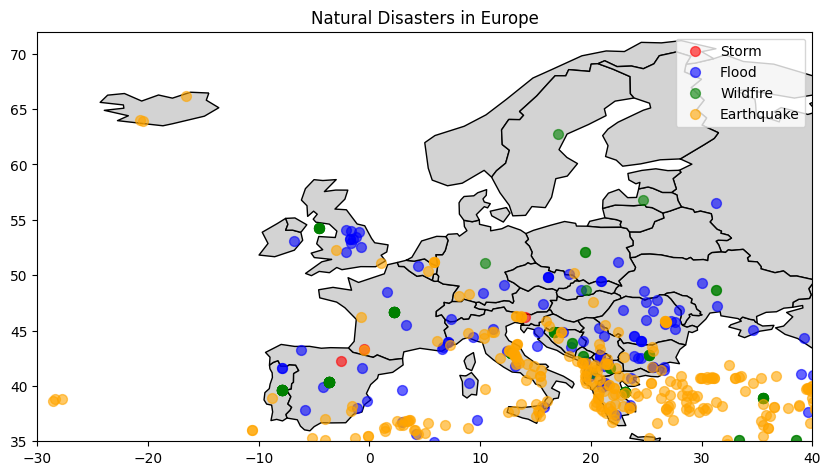

In [96]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load Europe map (Shapefile)
world = gpd.read_file("110m_cultural/ne_110m_admin_0_countries.shp")

# Filter for Europe
europe = world[world["CONTINENT"] == "Europe"]

# Plot Europe map
fig, ax = plt.subplots(figsize=(10, 8))
europe.plot(ax=ax, color="lightgrey", edgecolor="black")

# Filter disasters by type (Storm, Flood, Wildfire, Earthquake)
disaster_types = ["Storm", "Flood", "Wildfire", "Earthquake"]

# Colors for each disaster type
disaster_colors = {
    "Storm": "red",
    "Flood": "blue",
    "Wildfire": "green",
    "Earthquake": "orange"
}

# Plot each disaster type with a different color
for disaster_type in disaster_types:
    gdf_disasters[gdf_disasters["Disaster Type"] == disaster_type].plot(
        ax=ax, 
        markersize=50, 
        color=disaster_colors[disaster_type], 
        alpha=0.6, 
        label=disaster_type
    )

# Set limits for Europe
ax.set_xlim(-30, 40)  # Longitude range for Europe
ax.set_ylim(35, 72)   # Latitude range for Europe

# Add labels and legend
plt.legend()
plt.title("Natural Disasters in Europe")
plt.show()


In [100]:
# Filter entries for Spain
europe_entries = df[df["Region"] == "Europe"]

# Count the number of entries
num_europe_entries = len(europe_entries)

print(f"Number of entries from Europe: {num_europe_entries}")

# Group by Disaster Type and count occurrences
disaster_counts_europe = europe_entries["Disaster Type"].value_counts()

# Print results
print(disaster_counts_europe)

Number of entries from Europe: 3399
Disaster Type
Flood                               695
Storm                               611
Extreme temperature                 338
Air                                 268
Earthquake                          205
Water                               175
Road                                166
Rail                                154
Wildfire                            130
Explosion (Industrial)              124
Fire (Miscellaneous)                124
Mass movement (wet)                  86
Drought                              51
Epidemic                             39
Fire (Industrial)                    39
Explosion (Miscellaneous)            36
Miscellaneous accident (General)     35
Collapse (Miscellaneous)             33
Chemical spill                       32
Volcanic activity                    12
Poisoning                            10
Gas leak                             10
Collapse (Industrial)                 9
Industrial accident (General) 

In [101]:
# Filter disaster events for Spain (Floods and Storms)
disaster_europe = df[df['Region'] == "Europe"]
# Convert disaster data to GeoDataFrame
gdf_disasters_europe = gpd.GeoDataFrame(disaster_europe, geometry=gpd.points_from_xy(disaster_europe["Longitude"], disaster_europe["Latitude"]))
storms_europe = gdf_disasters_europe[gdf_disasters_europe["Disaster Type"] == "Storm"]
print(storms_europe.shape)  # Print the number of rows (should be > 0 if there are storms)
print(storms_europe[['Latitude', 'Longitude']].head())

(611, 19)
     Latitude  Longitude
256   19.4328    104.125
327   19.4328    104.125
328   19.4328    104.125
343   19.4328    104.125
356   19.4328    104.125


In [2]:
pip install xgboost

  Using cached xgboost-2.1.4-py3-none-macosx_12_0_arm64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.4-py3-none-macosx_12_0_arm64.whl (1.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import xgboost as xgb
# read in data
dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
dtest = xgb.DMatrix('demo/data/agaricus.txt.test')
# specify parameters via map
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

XGBoostError: [19:38:53] /Users/runner/work/xgboost/xgboost/src/data/file_iterator.cc:27: Check failed: name_args.size() == 2 (1 vs. 2) : URI parameter `format` is required for loading text data: filename?format=csv
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000016b46c428 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000016b5df980 xgboost::data::ValidateFileFormat(std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>> const&) + 536
  [bt] (2) 3   libxgboost.dylib                    0x000000016b5dae10 xgboost::DMatrix::Load(std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>> const&, bool, xgboost::DataSplitMode) + 1284
  [bt] (3) 4   libxgboost.dylib                    0x000000016b472a10 XGDMatrixCreateFromURI + 452
  [bt] (4) 5   libffi.8.dylib                      0x00000001013ac04c ffi_call_SYSV + 76
  [bt] (5) 6   libffi.8.dylib                      0x00000001013a9834 ffi_call_int + 1404
  [bt] (6) 7   _ctypes.cpython-312-darwin.so       0x000000010138c110 _ctypes_callproc + 756
  [bt] (7) 8   _ctypes.cpython-312-darwin.so       0x0000000101385f8c PyCFuncPtr_call + 232
  [bt] (8) 9   python3.12                          0x0000000100aab6b8 _PyEval_EvalFrameDefault + 192068

